# Imports & Configuration

In [188]:
import os
import time
import logging
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from typing import Union, List, Literal
from tsforecast import TSModel, Preprocessing
from sklearn.metrics import mean_squared_error
%matplotlib inline


logging.basicConfig(level=logging.INFO, format="%(asctime)s %(levelname)s:%(message)s")
LOGGER = logging.getLogger(__name__)

# Read input data

In [3]:
metric_list = ["317694", "317709", "317711", "317768", "389614"]
data = pd.read_csv("../../.data/метрики_торгового_эквайринга.csv", usecols=["datetime", *metric_list], parse_dates=["datetime"])

print(data.shape)
display(data.head())

(1725120, 6)


,datetime,317694,317709,317711,317768,389614
0,2020-01-01 00:00:00,0.0,0.0,0.0,2.0,NaN
1,2020-01-01 00:01:00,0.0,0.0,0.0,1.0,NaN
2,2020-01-01 00:02:00,0.0,0.0,0.0,0.0,NaN
3,2020-01-01 00:03:00,0.0,0.0,0.0,1.0,NaN
4,2020-01-01 00:04:00,0.0,0.0,0.0,4.0,NaN


In [13]:
data.dtypes

datetime    datetime64[ns]
317694             float64
317709             float64
317711             float64
317768             float64
389614             float64
dtype: object

# Evaluation

In [170]:
def forecast(data: pd.DataFrame, model_params: dict = {}, roles: dict = {}, train_size: int = 28, horizon: int = 1, step: int = 1, 
             stages: List[Literal["extend_time", "interpolate"]] = ["extend_time", "interpolate"], logs: str = "./logs.txt", 
             forecast_path: str = "./forecast.csv") -> None:
    datetime_col = roles.get("datetime") if (isinstance(roles, dict) and roles.get("datetime")) else "datetime"
    datetime_min, datetime_max = data[datetime_col].agg(["min", "max"])
    LOGGER.debug("Datetime\tfrom %s to %s" % (datetime_min, datetime_max))

    pp = Preprocessing(roles=roles, stages=stages)

    if not os.path.exists(forecast_path):
        with open(forecast_path, "w") as f:
            f.write("metric_id,datetime,forecast,trend,seasonal\n")

    if not os.path.exists(logs):
        with open(logs, "w") as f:
            f.write("metric_id,train_start,train_end,pred_start,pred_end,inference_time,mse\n")

    pred_start = datetime_min.normalize() + pd.Timedelta(days=train_size)
    LOGGER.debug("Iterate over dates")
    while pred_start + pd.Timedelta(days=horizon, minutes=-1) < datetime_max:
        train_start, train_end = pred_start - pd.Timedelta(days=train_size), pred_start - pd.Timedelta(minutes=1)
        pred_end = pred_start + pd.Timedelta(days=horizon, minutes=-1)
        LOGGER.debug("Train\tfrom %s to %s" % (train_start, train_end))
        LOGGER.debug("Prediction\tfrom %s to %s" % (pred_start, pred_end))

        trainset = data[(data[datetime_col] >= train_start) & (data[datetime_col] <= train_end)]
        testset = data[(data[datetime_col] >= pred_start) & (data[datetime_col] <= pred_end)]
        LOGGER.debug("Train size:\t%s" % len(trainset))
        LOGGER.debug("Test size:\t\t%s" % len(testset))

        LOGGER.debug("Train data preprocessing")
        trainset = pp(trainset)

        LOGGER.debug("Forecasting")
        model = TSModel(**model_params)
        try:
            start = time.time()
            forecast, trend, seasonal = model.fit_predict(data=trainset, horizon=horizon)
            end = time.time()
            timeline = pd.date_range(start=pred_start, end=pred_end, freq="1T")
            forecast = pd.DataFrame(data={
                "metric_id": roles.get("value"),
                "datetime": timeline, 
                "forecast": forecast, 
                "trend":    trend, 
                "seasonal": seasonal})
            LOGGER.debug("Forecast size:\t%s" % len(forecast))

            forecast.to_csv(forecast_path, mode="a", index=False, header=False)
            LOGGER.debug("Forecast saved")

            LOGGER.debug("MSE calculation:\t%s" % len(forecast))
            testset = testset.merge(forecast[["datetime", "forecast"]], how="left", on="datetime")
            testset = testset.dropna(axis=0, how="any")
            if not testset.empty:
                mse = mean_squared_error(testset[roles.get("value")].values, testset["forecast"])
            else:
                mse = ""

            with open(logs, "a") as f:
                f.write("%s,%s,%s,%s,%s,%s,%s\n" % (roles.get("value"), train_start, train_end, pred_start, pred_end, end - start, mse))
                LOGGER.debug("Logs saved")

        except ValueError:
            with open(logs, "a") as f:
                f.write("%s,%s,%s,%s,%s,%s,%s\n" % (roles.get("value"), train_start, train_end, pred_start, pred_end, "", ""))
                LOGGER.debug("Logs saved")

        pred_start += pd.Timedelta(days=step)
    return


In [171]:
logs = "./logs.txt"
forecast_path = "./forecast.csv"

if os.path.exists(logs):
    os.remove(logs)
if os.path.exists(forecast_path):
    os.remove(forecast_path)

for metric_id in data.columns.drop("datetime"):
    roles = {"value": metric_id}
    model_params = dict(
        h_size=28, 
        trend="linear",
        roles=roles,
        seasonal_type="weekly",
        agg_f="median",
        model_type="multiplicative",
    )
    forecast(data=data.loc[:, ["datetime", metric_id]], model_params=model_params, roles=roles, horizon=1, step=1, logs=logs, forecast_path=forecast_path)

# Results visualization

## Read logs / forecast

In [177]:
log_results = pd.read_csv("./logs.txt", parse_dates=[1, 2, 3, 4])

print(log_results.shape)
display(log_results.head())

(5845, 7)


,metric_id,train_start,train_end,pred_start,pred_end,inference_time,mse
0,317694,2020-01-01,2020-01-28 23:59:00,2020-01-29,2020-01-29 23:59:00,0.010004,15313.879237
1,317694,2020-01-02,2020-01-29 23:59:00,2020-01-30,2020-01-30 23:59:00,0.008986,14018.321587
2,317694,2020-01-03,2020-01-30 23:59:00,2020-01-31,2020-01-31 23:59:00,0.009998,18597.550030
3,317694,2020-01-04,2020-01-31 23:59:00,2020-02-01,2020-02-01 23:59:00,0.009999,18577.551573
4,317694,2020-01-05,2020-02-01 23:59:00,2020-02-02,2020-02-02 23:59:00,0.011000,20705.034163


In [204]:
holidays = {
        "Новый Год": [
                ("2021-01-01", "2021-01-06"), 
                ("2021-01-08", "2021-01-08"),
            ],
        "Рождество Христово": [
                ("2021-01-07", "2021-01-07"),
            ],
        "День защитника отечества": [
                ("2021-02-23", "2021-02-23"),
            ],
        "8 марта": [
                ("2021-03-08", "2021-03-08"),
            ],
        "Нерабочие дни": [
                ("2021-02-22", "2021-02-22"),
            ],
        "Рабочие перенесенные дни": [
                ("2021-02-20", "2021-02-20"),
            ]
    }

C:\Users\alpex\AppData\Local\Temp\ipykernel_19356\3643403050.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show();


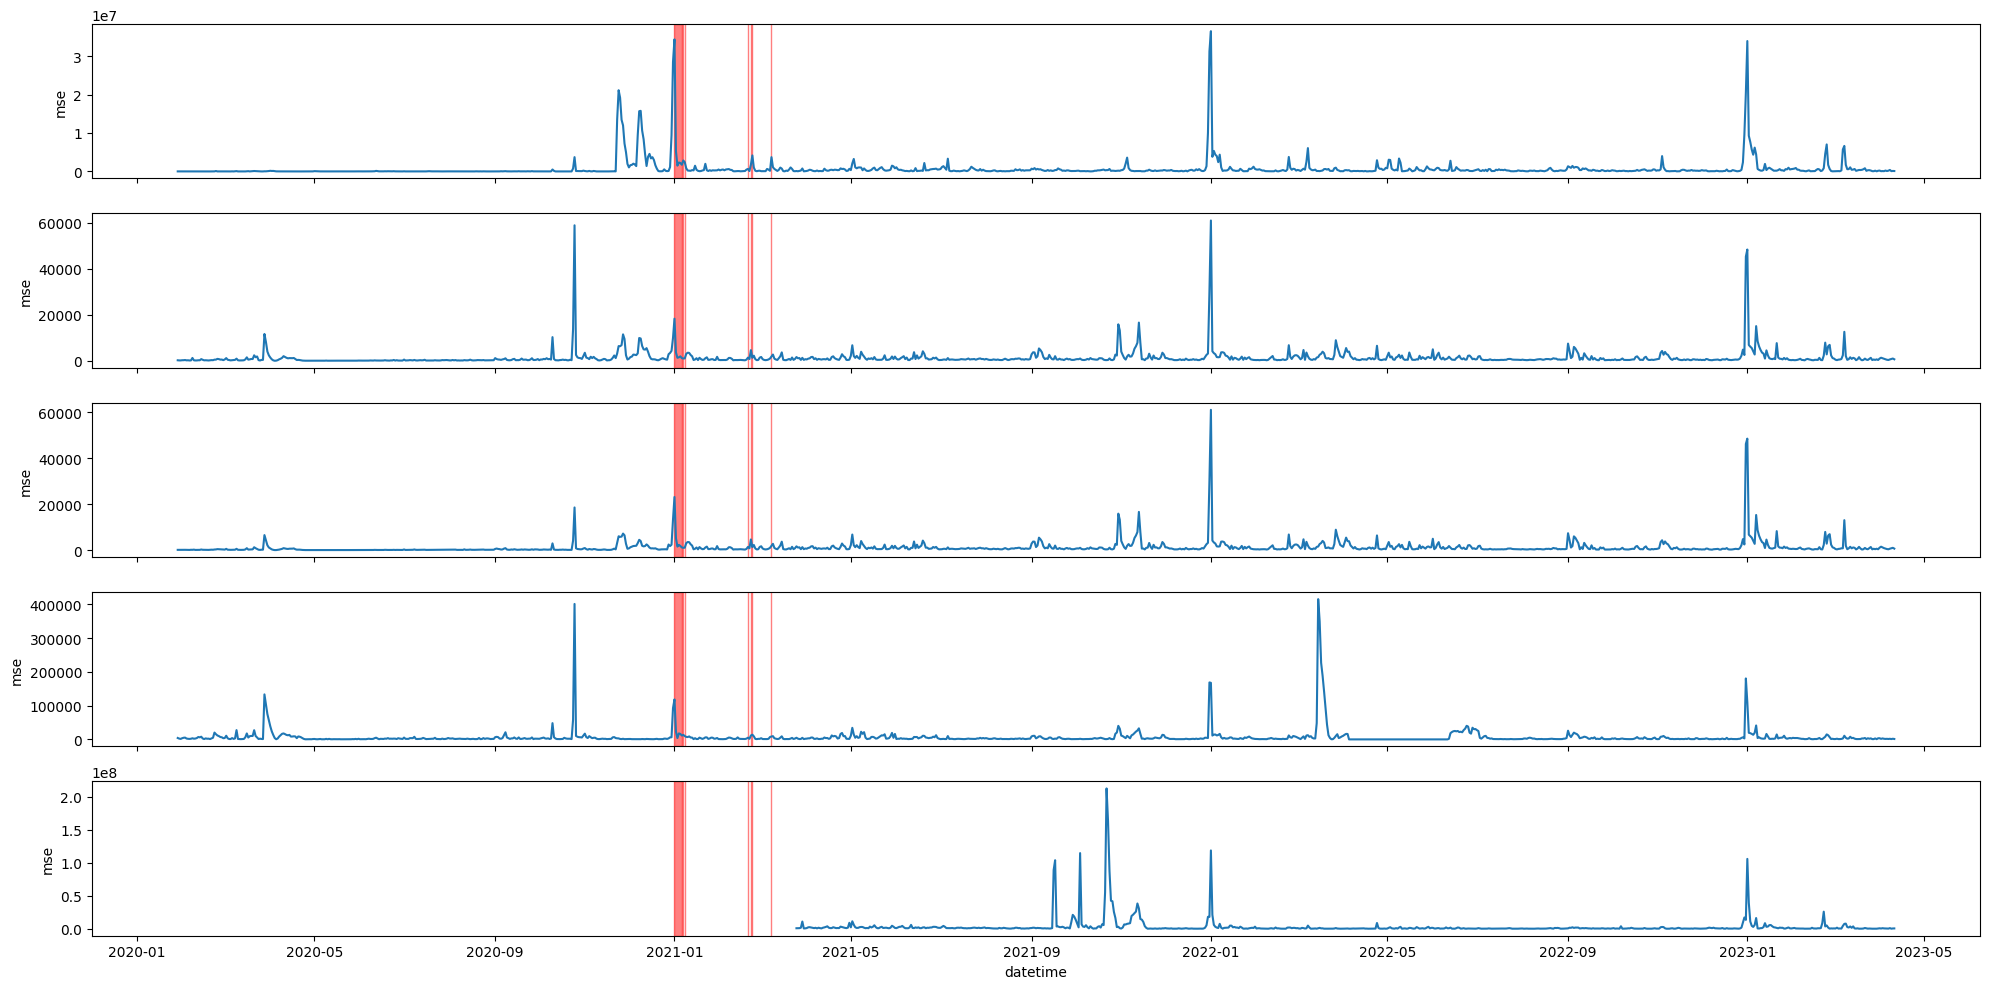

In [206]:
groups = log_results.groupby(by="metric_id")
n_groups = len(groups)
fig, ax = plt.subplots(nrows=n_groups, figsize=(20, 2*n_groups), sharex=True)
for idx, (metric_id, metric_logs) in enumerate(groups):
    sns.lineplot(data=metric_logs, x="pred_start", y="mse", ax=ax[idx])
    ax[idx].set_xlabel("datetime")

    for holiday_name, dates in holidays.items():
        for date_from, date_to in dates:
            ax[idx].axvspan(xmin=pd.Timestamp(date_from), 
                            xmax=pd.Timestamp(date_to), color="red", alpha=0.5)
fig.tight_layout()
fig.show();